
# Proyecto
### Pregunta:
Cuál es la trayectori de las ondas sísmicas medidas desde Panamá del sismo de Kamchatka del 29 de Julio del 2025?

In [105]:
import math
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
import matplotlib.dates as mdates


from obspy.taup import TauPyModel

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## Funciones auxiliares

In [13]:
def normalize_phases(phases_str):
    """
    Normaliza lista separada por comas: quita espacios y ajusta casos típicos.
    E.g., 'p, s , PCP' -> ['P', 'S', 'PcP']
    """
    canonical = {
        "PCP": "PcP", "SCS": "ScS", "PKP": "PKP", "SKS": "SKS",
        "PKIKP": "PKiKP", "PDIFF": "Pdiff", "SDIFF": "Sdiff"
    }
    phases = []
    for p in phases_str.split(","):
        p = p.strip()
        if not p:
            continue
        u = p.upper()
        phases.append(canonical.get(u, u))
    phases = list(dict.fromkeys(phases))
    return phases


def compute_travel_times(model, depth_km, distances_deg, phases):
    """Devuelve {fase: np.array(tiempos_en_seg)} con NaN cuando no hay arribo."""
    results = {ph: [] for ph in phases}
    for d in distances_deg:
        for ph in phases:
            try:
                arrivals = model.get_travel_times(
                    source_depth_in_km=depth_km,
                    distance_in_degree=d,
                    phase_list=[ph]
                )
                if len(arrivals) == 0:
                    results[ph].append(np.nan)
                else:
                    t_min = min(a.time for a in arrivals)
                    results[ph].append(t_min)
            except Exception:
                results[ph].append(np.nan)
    for ph in phases:
        results[ph] = np.array(results[ph], dtype=float)
    return results


def plot_time_distance(distances_deg, tt_dict, model_name, depth_km, outfile="tiempo_trayecto.png"):
    plt.figure(figsize=(9, 6))
    for ph, arr in tt_dict.items():
        if np.all(np.isnan(arr)):
            continue
        plt.plot(distances_deg, arr, label=ph)  # Sin especificar colores
    plt.xlabel("Distancia (°)")
    plt.ylabel("Tiempo de llegada (s)")
    plt.title(f"Curvas tiempo–trayecto | Modelo: {model_name} | Profundidad: {depth_km} km")
    plt.axvline(x=99.97, linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    try:
        plt.savefig(outfile, dpi=150)
        print(f"✔ Figura guardada: {outfile}")
    except Exception as e:
        print(f"Advertencia: no se pudo guardar {outfile}: {e}")
    plt.show()


def plot_ray_paths_circular(model, depth_km, distance_deg, phases, outfile="ray_paths_polar.png"):
    """Grafica trayectorias de rayos en un esquema circular (proyección polar)."""
    try:
        arrivals = model.get_ray_paths(
            source_depth_in_km=depth_km,
            phase_list=phases,
            distance_in_degree=distance_deg
        )
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
        arrivals.plot_rays(ax=ax)  # usa estilo de TauP; no especificar colores
        ax.set_title(f"Trayectorias de rayos sísmicos\nProfundidad: {depth_km} km | Δ={distance_deg}°")
        fig.savefig(outfile, dpi=150)
        print(f"✔ Figura guardada: {outfile}")
        plt.show()
    except ValueError as e:
        print(f"No se pudieron calcular trayectorias de rayos: {e}")


## Parámetros de la actividad
Edita las variables de esta celda y vuelve a ejecutar para probar distintos escenarios.


In [86]:
# --- Parámetros ---
model_name = "iasp91"        # "iasp91", "prem" o "ak135"
depth_km = 35              # Profundidad de la fuente (km)
dmin, dmax = 70.0, 110.0      # Rango de distancias (grados)
n_stations = 1000             # Número de puntos de muestreo en el eje de distancia
phases_str = "P, s, P, SP, PS, PP, SS, S, Pn, Sn, PcP, ScS, Pdiff, Sdiff, PKP, SKS, PKiKP, SKiKS, PKIKP, SKIKS"  # Fases separadas por comas
#phases_str="SKS"
# Para ray paths (puedes ajustar manualmente)
distance_for_rays = 99.97     # Δ en grados para el diagrama circular

# --- Construcción de objetos/arrays ---
model = TauPyModel(model=model_name)
distances = np.linspace(dmin, dmax, int(n_stations))
phases = normalize_phases(phases_str)

print("Modelo:", model_name)
print("Profundidad (km):", depth_km)
print("Rango de distancias (°):", dmin, "→", dmax, "| puntos:", len(distances))
print("Fases:", phases)
print("Δ para ray paths (°):", distance_for_rays)

Modelo: iasp91
Profundidad (km): 35
Rango de distancias (°): 70.0 → 110.0 | puntos: 1000
Fases: ['P', 'S', 'SP', 'PS', 'PP', 'SS', 'PN', 'SN', 'PcP', 'ScS', 'Pdiff', 'Sdiff', 'PKP', 'SKS', 'PKiKP', 'SKIKS']
Δ para ray paths (°): 99.97


## Cálculo de tiempos de llegada y figura tiempo–trayecto

✔ Figura guardada: tiempo_trayecto.png


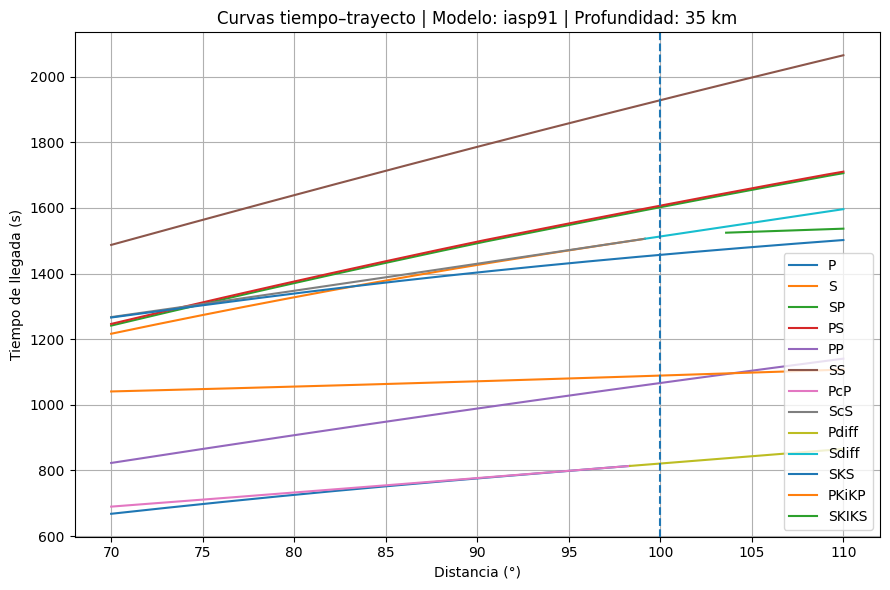

In [87]:
tt = compute_travel_times(model, depth_km, distances, phases)
plot_time_distance(distances, tt, model_name, depth_km, outfile="tiempo_trayecto.png")

## Ray paths en esquema circular (polar)

Intentando ray paths circulares a Δ=100.0° con fases: ['P', 'S', 'SP', 'PS', 'PP', 'SS', 'PcP', 'ScS', 'Pdiff', 'Sdiff', 'SKS', 'PKiKP', 'SKIKS']


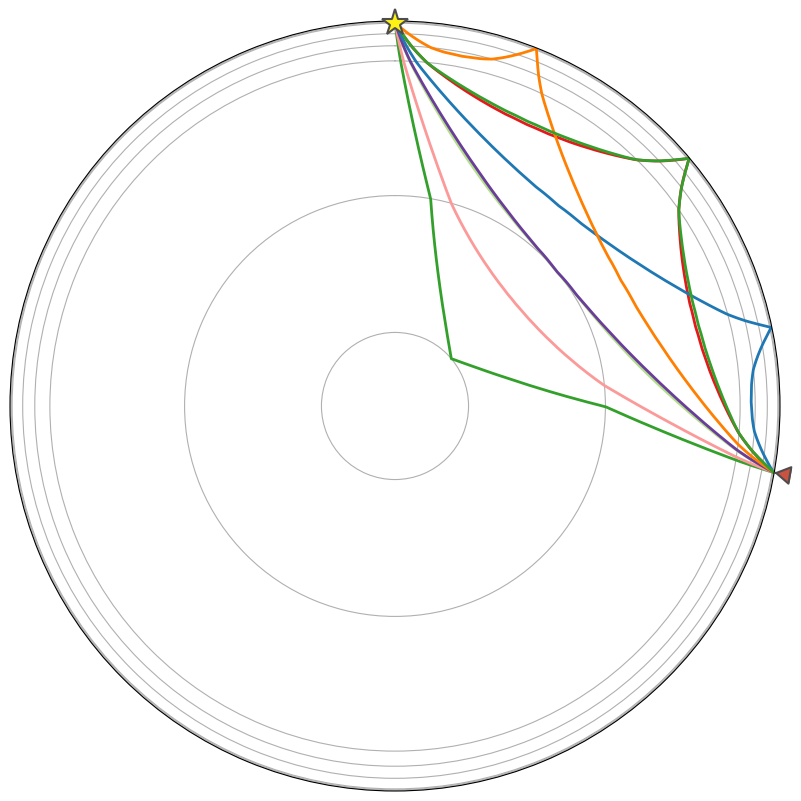

✔ Figura guardada: ray_paths_polar.png


In [49]:
# Usamos la distancia definida en 'distance_for_rays'
phases_with_any = [ph for ph, arr in tt.items() if np.any(~np.isnan(arr))]
print(f"Intentando ray paths circulares a Δ={distance_for_rays:.1f}° con fases: {phases_with_any}")
if len(phases_with_any) > 0:
    plot_ray_paths_circular(model, depth_km, distance_for_rays, phases_with_any, outfile="ray_paths_polar.png")
else:
    print("No hay fases con llegadas en el rango dado; ajusta parámetros o fases.")

In [93]:
#Calcula el tiempo de llegada de cada uno y devuelve el tiempo de llegada de P 
#y las diferencias de tiempos de llegada entre P y cada una de las demás fases
def tiempo_de_llegada(tt,distances,dist):
    distances=distances.tolist()
    for distance in distances[1:]:
        if dist/distance<1.005 and dist/distance>0.995:
            new_dist=distance
        if dist<=20 and dist>=8:
            if dist/distance<1.01 and dist/distance>0.99:
                new_dist=distance
        if dist<=7.999999:
            if dist/distance<1.06 and dist/distance>0.92:
                new_dist=distance
        

    position=distances.index(new_dist)
    times={'P':824.49,'S':tt['S'][position]-824.49,'SP':tt['SP'][position]-824.49,'PS':tt['PS'][position]-824.49,'PP':tt['PP'][position]-824.49,'SS':tt['SS'][position]-824.49,'Pn':tt['PN'][position]-824.49,'PcP':tt['PcP'][position]-824.49,'ScS':tt['ScS'][position]-824.49,'Pdiff':tt['Pdiff'][position]-824.49,'Sdiff':tt['Sdiff'][position]-824.49,'PKP':tt['PKP'][position]-824.49,'SKS':tt['SKS'][position]-824.49,'PKiKP':tt['PKiKP'][position]-824.49,'SKIKS':tt['SKIKS'][position]-824.49}
    return times,new_dist

Tiempo de llegada de P calculado con los tiempos de Wilbur 3
$$
\begin{align}
t_{Llegada P}&=\Delta t_{PP-P\_Wilbur3} -t_{PP calculado}\\
&=824.49s
\end{align}
$$

In [95]:
#Tiempos teóricos de llegada
tiempo_de_llegada(tt,distances,99.9)

({'P': 824.49,
  'S': nan,
  'SP': 781.7974581347219,
  'PS': 786.5021883565628,
  'PP': 245.00537270241648,
  'SS': 1109.0814152820856,
  'Pn': nan,
  'PcP': nan,
  'ScS': nan,
  'Pdiff': -1.5929069683725174,
  'Sdiff': 691.6718705927274,
  'PKP': nan,
  'SKS': 634.3560433547225,
  'PKiKP': 265.27094401963063,
  'SKIKS': nan},
 100.3903903903904)

## Tiempos de llegada:

P: 23:38:33 (Según Wilber3, según cálculos no llega)\
S: 23:50:04 (Según Wilber3, según cálculos no llega)\
SP: 23:51:35 \
PS: 23:51:40 \
PP: 23:42:38 (Según Wilber3 y confirmada con cálculos)\
SS: 23:56:59 (Según Wilber3 y confirmada con cálculos 23:57:02)\
Pdiff: 23:38:31 \
Sdiff: 23:50:05\
SKS: 23:49:08 (Según Wilber3 y confirmada con cálculos 23:59:07) \
PKiKP: 23:42:58\


### Cargar Archivo

In [112]:
file = read('2025-07-29mww88off-east-coast-of-kamchatka.miniseed')
file.plot(outfile="sismogramas_crudos.png")
file[0].stats.starttime

2025-07-29T23:37:33.019538Z

In [127]:
target_timeP = file[0].stats.starttime + 1*60 + 0   # add 20 min 20 sec
target_mpl_timeP = mdates.date2num(target_timeP.datetime)

target_timeS = file[0].stats.starttime + 13*60 -29   # add 20 min 20 sec
target_mpl_timeS = mdates.date2num(target_timeS.datetime)

target_timeSP = file[0].stats.starttime + 14*60 + 2   # add 20 min 20 sec
target_mpl_timeSP = mdates.date2num(target_timeSP.datetime)

target_timePS = file[0].stats.starttime + 14*60 + 7   # add 20 min 20 sec
target_mpl_timePS = mdates.date2num(target_timePS.datetime)

target_timePP = file[0].stats.starttime + 5*60 + 5   # add 20 min 20 sec
target_mpl_timePP = mdates.date2num(target_timePP.datetime)

target_timeSS = file[0].stats.starttime + 19*60 + 26   # add 20 min 20 sec
target_mpl_timeSS = mdates.date2num(target_timeSS.datetime)

target_timePdiff = file[0].stats.starttime + 1*60 - 2   # add 20 min 20 sec
target_mpl_timePdiff = mdates.date2num(target_timePdiff.datetime)

target_timeSdiff = file[0].stats.starttime + 13*60 -28   # add 20 min 20 sec
target_mpl_timeSdiff = mdates.date2num(target_timeSdiff.datetime)

target_timeSKS = file[0].stats.starttime + 12*60 - 25   # add 20 min 20 sec
target_mpl_timeSKS = mdates.date2num(target_timeSKS.datetime)

target_timePK = file[0].stats.starttime + 5*60 + 25   # add 20 min 20 sec
target_mpl_timePK = mdates.date2num(target_timePK.datetime)

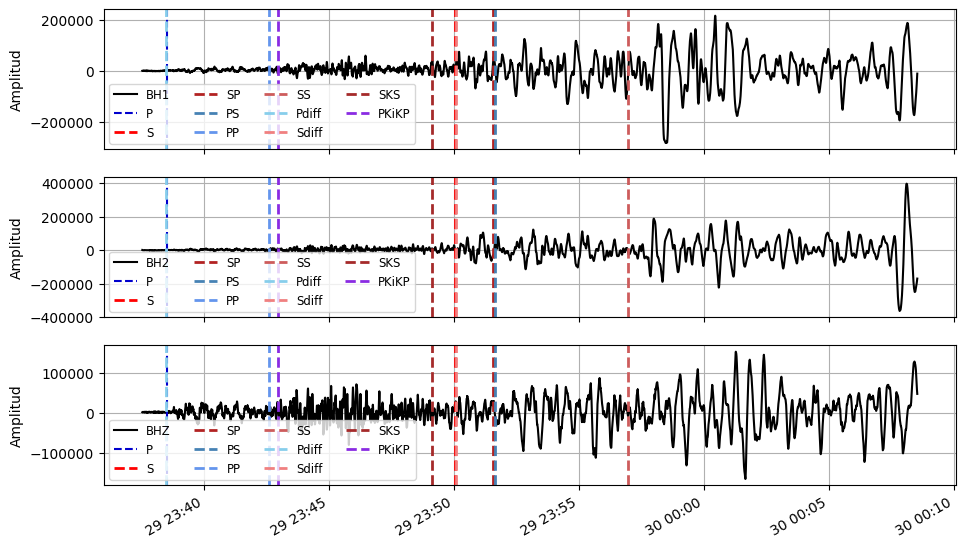

In [142]:
#PLot
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(11, 7))
ax[0].plot(file[0].times("matplotlib"), file[0].data, color='black',label='BH1')
ax[1].plot(file[1].times("matplotlib"), file[1].data, color='black',label='BH2')
ax[2].plot(file[2].times("matplotlib"), file[2].data, color='black',label='BHZ')
ax[2].xaxis_date()

for axn in ax:
    axn.set_ylabel('Amplitud') 
    axn.axvline(target_mpl_timeP, color='mediumblue', linestyle='--', linewidth=1.5,label='P')
    axn.axvline(target_mpl_timeS, color='red', linestyle='--', linewidth=1.5,label='S')
    axn.axvline(target_mpl_timeSP, color='firebrick', linestyle='--', linewidth=1.5,label='SP')
    axn.axvline(target_mpl_timePS, color='steelblue', linestyle='--', linewidth=1.5,label='PS')
    axn.axvline(target_mpl_timePP, color='cornflowerblue', linestyle='--', linewidth=1.5,label='PP')
    axn.axvline(target_mpl_timeSS, color='indianred', linestyle='--', linewidth=1.5,label='SS')
    axn.axvline(target_mpl_timePdiff, color='skyblue', linestyle='--', linewidth=1.5,label='Pdiff')
    axn.axvline(target_mpl_timeSdiff, color='lightcoral', linestyle='--', linewidth=1.5,label='Sdiff')
    axn.axvline(target_mpl_timeSKS, color='brown', linestyle='--', linewidth=2,label='SKS')
    axn.axvline(target_mpl_timePK, color='blueviolet', linestyle='--', linewidth=2,label='PKiKP')
    axn.legend(loc='lower left', fontsize='small',ncol=4)
    axn.grid(True)

#plt.legend()
fig.autofmt_xdate()
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'xaxis_date'

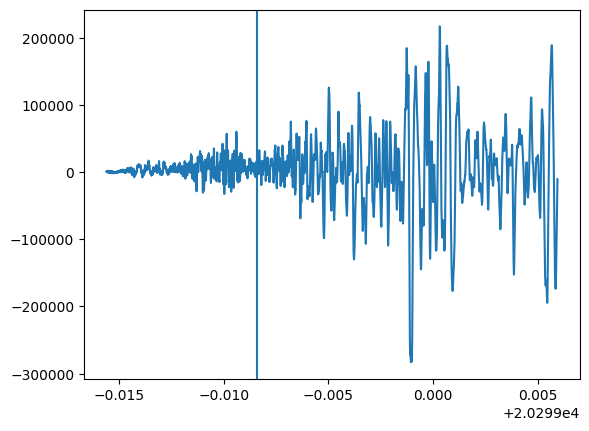

In [110]:
plt.plot(file[0].times("matplotlib"), file[0].data)
target_time = file[0].stats.starttime + 10*60 + 20   # add 20 min 20 sec
target_mpl_time = mdates.date2num(target_time.datetime)
plt.axvline(target_mpl_time)
plt.xaxis_date()
fig.autofmt_xdate()
plt.show()

In [103]:
file[0].times("matplotlib")

array([20298.98440995, 20298.98441024, 20298.98441053, ...,
       20299.00593686, 20299.00593715, 20299.00593744])

## Exportar tabla (CSV) de tiempos de llegada

In [31]:
import csv
out_csv = "tiempos_llegada.csv"
with open(out_csv, "w", newline="") as f:
    writer = csv.writer(f)
    header = ["distance_deg"] + phases
    writer.writerow(header)
    for i, d in enumerate(distances):
        row = [f"{d:.4f}"]
        for ph in phases:
            val = tt[ph][i]
            row.append("" if (np.isnan(val)) else f"{val:.4f}")
        writer.writerow(row)
print(f"✔ CSV guardado: {out_csv}")

✔ CSV guardado: tiempos_llegada.csv
